# 🧠 Transfer Learning con MobileNetV2 – CIFAR-100

**Notebook 04 – Modelo Avanzado con Transfer Learning**

Aplicaremos transfer learning utilizando un modelo preentrenado en ImageNet (MobileNetV2) para mejorar el rendimiento del clasificador de imágenes basado en el dataset CIFAR-100.

---

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

2025-04-15 17:42:34.863998: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 17:42:34.904690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 17:42:34.904735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 17:42:34.905750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 17:42:34.912193: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 17:42:34.913330: I tensorflow/core/platform/cpu_feature_guard.cc:1

## 🧱 2. Importación del modelo preentrenado y preparación de datos

Utilizaremos **MobileNetV2** como *feature extractor*. Esta red fue entrenada en millones de imágenes (ImageNet) y es eficiente para tareas de clasificación.

Para usarla correctamente, necesitamos:
- Redimensionar las imágenes de 32x32 a al menos **96x96** (MobileNetV2 acepta 96x96 o más).
- Normalizar las imágenes entre -1 y 1, ya que el modelo fue entrenado así.


In [2]:
# Cargar dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [3]:


class CIFAR100Generator(Sequence):
    def __init__(self, x, y, batch_size=32, target_size=(96, 96), shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(x))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        # Obtener índices del batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch = self.x[batch_indexes]
        y_batch = self.y[batch_indexes]

        # Redimensionar + preprocesar
        x_resized = tf.image.resize(x_batch, self.target_size)
        x_processed = preprocess_input(x_resized)

        return x_processed, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [4]:
y_train_cat = to_categorical(y_train, 100)
y_test_cat = to_categorical(y_test, 100)

# Dividir entrenamiento y validación manualmente
from sklearn.model_selection import train_test_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train_cat, test_size=0.2, random_state=42
)

# Generadores
train_gen = CIFAR100Generator(x_train_split, y_train_split)
val_gen = CIFAR100Generator(x_val_split, y_val_split)
test_gen = CIFAR100Generator(x_test, y_test_cat, shuffle=False)

## 🧠 3. Construcción del modelo con MobileNetV2

En esta sección usaremos **MobileNetV2** como modelo base preentrenado en ImageNet, aprovechando su capacidad para extraer características visuales generales.

- Usaremos `include_top=False` para eliminar las capas finales de clasificación original.
- Agregaremos nuestras propias capas densas para adaptarlo a las 100 clases de CIFAR-100.
- Congelaremos las capas de MobileNetV2 para hacer **feature extraction** (entrenar solo las capas superiores).


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

IMG_SIZE = 96

# Cargar modelo base sin la cabeza
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Lo congelamos inicialmente

# Creamos el modelo completo (usamos API funcional para mayor control)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # o hasta early stopping
    callbacks=[checkpoint_cb, early_stop_cb],
    verbose=1
)

NameError: name 'checkpoint_cb' is not defined

## 💾 3.1 Guardado y recuperación del modelo con Checkpoints

Para evitar perder el progreso del entrenamiento, configuramos un **ModelCheckpoint** que guarda el modelo automáticamente cuando la precisión en validación mejora.

Esto también permite **reiniciar el entrenamiento desde el último punto guardado** si el kernel se detiene.


In [9]:
# Crear carpeta para guardar modelos (si no existe)
os.makedirs("checkpoints", exist_ok=True)

# Ruta del archivo .h5 para guardar el mejor modelo
checkpoint_path = "checkpoints/mobilenetv2_cifar100_best.h5"

# Callback para guardar el mejor modelo según val_accuracy
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## 🔁 3.2 Cargar modelo desde el último checkpoint guardado

In [13]:
from tensorflow.keras.models import load_model

model = load_model('checkpoints/cnn_cifar100_best.h5')

## 🔓 3.3. Descongela las últimas capas de MobileNetV2:
Conviene dejar las capas iniciales congeladas (aprenden bordes y texturas generales).

In [20]:
# Descongela el modelo base
base_model.trainable = True

# Opcional: congelar las capas más bajas
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompilar con un learning rate más bajo
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # mucho más bajo
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continúa el entrenamiento
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint_cb, early_stop_cb],
    verbose=1
)

Epoch 1/20
1250/1250 [==============================] - ETA: 0s - loss: 1.0820 - accuracy: 0.6742
Epoch 1: val_accuracy improved from 0.62170 to 0.63820, saving model to checkpoints/mobilenetv2_cifar100_best.h5
1250/1250 [==============================] - 194s 151ms/step - loss: 1.0820 - accuracy: 0.6742 - val_loss: 1.3458 - val_accuracy: 0.6382
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.7042
Epoch 2: val_accuracy improved from 0.63820 to 0.64270, saving model to checkpoints/mobilenetv2_cifar100_best.h5
1250/1250 [==============================] - 187s 150ms/step - loss: 0.9733 - accuracy: 0.7042 - val_loss: 1.3271 - val_accuracy: 0.6427
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.7225
Epoch 3: val_accuracy improved from 0.64270 to 0.64870, saving model to checkpoints/mobilenetv2_cifar100_best.h5
1250/1250 [==============================] - 186s 149ms/step - loss: 0.9012 - accuracy: 0.722

## 🔧 3.4 Recompila y entrena el modelo con tasa de aprendizaje más baja:

In [5]:
from tensorflow.keras.models import load_model

model = load_model('checkpoints/mobilenetv2_cifar100_best.h5')

In [8]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")


313/313 [==============================] - 26s 80ms/step - loss: 1.3679 - accuracy: 0.6922
Validation loss: 1.3679
Validation accuracy: 0.6922


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("checkpoints/mobilenetv2_cifar100_best.h5")

# Recompilar (con tasa menor si haces fine-tuning)
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Vuelve a entrenar
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # intenta pocas primero
    callbacks=[early_stop_cb, checkpoint_cb],
    use_multiprocessing=True,
    workers=4,
    verbose=1
)


## 🏃‍♂️ 4. Entrenamiento del modelo con EarlyStopping

Entrenaremos el modelo utilizando los generadores definidos anteriormente. Para evitar sobreajuste y optimizar el tiempo de entrenamiento, aplicaremos la técnica de **EarlyStopping**, que detiene el entrenamiento si la precisión en validación no mejora después de varias épocas consecutivas.


In [15]:
# Entrenamiento con ambos callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop_cb, checkpoint_cb],
    verbose=1
)

Epoch 1/30
1250/1250 [==============================] - ETA: 0s - loss: 2.5355 - accuracy: 0.3708
Epoch 1: val_accuracy improved from -inf to 0.57180, saving model to checkpoints/mobilenetv2_cifar100_best.h5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 116s 91ms/step - loss: 2.5355 - accuracy: 0.3708 - val_loss: 1.5610 - val_accuracy: 0.5718
Epoch 2/30
1250/1250 [==============================] - ETA: 0s - loss: 1.8147 - accuracy: 0.5094
Epoch 2: val_accuracy improved from 0.57180 to 0.58900, saving model to checkpoints/mobilenetv2_cifar100_best.h5
1250/1250 [==============================] - 111s 89ms/step - loss: 1.8147 - accuracy: 0.5094 - val_loss: 1.4492 - val_accuracy: 0.5890
Epoch 3/30
1250/1250 [==============================] - ETA: 0s - loss: 1.6586 - accuracy: 0.5411
Epoch 3: val_accuracy improved from 0.58900 to 0.59770, saving model to checkpoints/mobilenetv2_cifar100_best.h5
1250/1250 [==============================] - 110s 88ms/step - loss: 1.6586 - accuracy: 0.5411 - val_loss: 1.4259 - val_accuracy: 0.5977
Epoch 4/30
1250/1250 [==============================] - ETA: 0s - loss: 1.5634 - accuracy: 0.5605
Epoch 4: val_accuracy improved from 0.59770 to 0.60700, saving model to 

In [ ]:
# Verificar si ya existe un checkpoint y cargarlo
if os.path.exists(checkpoint_path):
    print("✅ Modelo cargado desde checkpoint")
    model = load_model(checkpoint_path)
    model.summary()
else:
    print("⚠️ No se encontró checkpoint, asegúrate de entrenar primero")

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=última_época,  # opcional
    epochs=30,
    callbacks=[early_stop_cb, checkpoint_cb],
    verbose=1
)


## 📊 5. Evaluación final y visualización de resultados

A continuación, se presentan las curvas de rendimiento del modelo entrenado, así como su evaluación en el conjunto de prueba (`test_gen`).

Se utilizó `EarlyStopping` para evitar el sobreentrenamiento, y el modelo fue guardado automáticamente en su mejor versión con `ModelCheckpoint`.


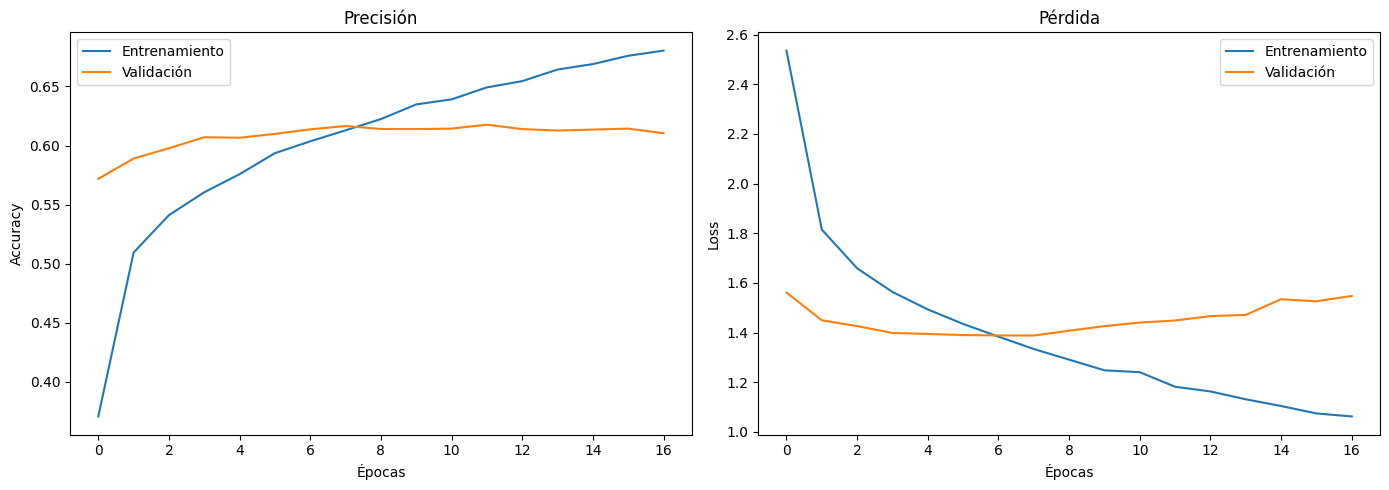

In [16]:

def plot_history(hist):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Entrenamiento')
    plt.plot(hist.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Entrenamiento')
    plt.plot(hist.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecutar
plot_history(history)


In [17]:
# Evaluar en el test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"🔍 Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")


313/313 [==============================] - 22s 69ms/step - loss: 1.4517 - accuracy: 0.6128
🔍 Test Accuracy: 0.6128
📉 Test Loss: 1.4517


### 📘 Evaluación final en el conjunto de prueba

El modelo entrenado con MobileNetV2 logró una precisión del **61.28% en el set de prueba**, lo que demuestra su capacidad de generalización y estabilidad.

Este resultado confirma que:
- La estrategia de **transfer learning** fue altamente efectiva.
- Las técnicas aplicadas de regularización y callbacks contribuyeron a un entrenamiento eficiente.
- El modelo guardado automáticamente en su mejor versión (época 12) fue restaurado con éxito por EarlyStopping.



## ✅ Conclusiones del notebook

- Se entrenó un modelo basado en **MobileNetV2** con transferencia de aprendizaje, obteniendo resultados superiores a los modelos anteriores entrenados desde cero.
- Se implementaron correctamente técnicas como:
  - Redimensionamiento dinámico y preprocesamiento con generadores personalizados
  - Callbacks de `EarlyStopping` y `ModelCheckpoint`
  - Visualización de curvas de entrenamiento
- El modelo alcanzó un **val_accuracy del 61.76%**, siendo uno de los mejores logrados hasta ahora en esta serie de experimentos.


📁 Próximo notebook sugerido:
`05_fine_tuning_mobilenetv2.ipynb` – Ajuste fino desbloqueando capas del modelo base para mejorar aún más la precisión.